In [1]:
using CSV
using DataFrames
using Printf
using LinearAlgebra
using Statistics
using StatsBase
using PyPlot
using PorousMaterials: fit_adsorption_isotherm, read_atomic_masses, FitError
using LaTeXStrings
using ProgressMeter
using HTTP
using JSON
using Optim
using JLD2

┌ Info: Precompiling PorousMaterials [top-level]
└ @ Base loading.jl:1273


In [2]:
USE_LOCAL_FILES_IF_AVAILABLE = true

true

## Lets start by loading in information from the NIST DB

In [3]:
host = "https://adsorption.nist.gov"

"https://adsorption.nist.gov"

In [4]:
url = host * "/api/version.json"
r = HTTP.request("POST", url)
new_version_data = JSON.parse(String(r.body))
if USE_LOCAL_FILES_IF_AVAILABLE
    @load joinpath("data", "version.jld2") version_data
    if new_version_data["version"] != version_data["version"]
        @warn @sprintf("A new version has been released. Think about rerunning the notebook with `USE_LOCAL_FILES_IF_AVAILABLE = false`\n
            Current version: %s\n New version: %s\n
            Comment from new version: %s\n", version_data["version"], new_version_data["version"], new_version_data["comment"])
    else
        @printf("Your version is up to date\nCurrent version: %s\nLast updated: %s\n", version_data["version"], version_data["date"])
    end
else
    version_data = deepcopy(new_version_data)
    @save joinpath("data", "version.jld2") version_data
end
    

Your version is up to date
Current version: 3.8881
Last updated: 2020-01-14 15:34:36


### Gases:

In [5]:
key_to_gas = Dict{AbstractString, AbstractString}()
if isfile(joinpath("data", "key_to_gas.jld2")) && USE_LOCAL_FILES_IF_AVAILABLE
    @load joinpath("data", "key_to_gas.jld2") key_to_gas
else
    @printf("Downloading data from the NIST DB\n")
    url = host * "/isodb/api/gases.json"
    r = HTTP.request("POST", url)
    gas_data = JSON.parse(String(r.body))

    for gas in gas_data
        key_to_gas[gas["InChIKey"]] = gas["name"]
    end
    @save joinpath("data", "key_to_gas.jld2") key_to_gas
end
println("how many gases? ", length(key_to_gas))

how many gases? 356


### Porous Materials

In [6]:
key_to_material = Dict{AbstractString, AbstractString}()
if isfile(joinpath("data", "key_to_material.jld2")) && USE_LOCAL_FILES_IF_AVAILABLE
    @load joinpath("data", "key_to_material.jld2") key_to_material
else
    @printf("Downloading data from the NIST DB\n")
    url = host * "/isodb/api/materials.json"
    r = HTTP.request("POST", url)
    material_data = JSON.parse(String(r.body))

    for material in material_data
        key_to_material[material["hashkey"]] = material["name"]
    end
    @save joinpath("data", "key_to_material.jld2") key_to_material
end
println("how many materials? ", length(key_to_material))

how many materials? 7007


In [7]:
master_list_of_gases = collect(values(key_to_gas));
master_list_of_materials = collect(values(key_to_material));

#### Plenty of materials/gases will be removed or merged due to:
* Not being experimental
* Not being within our temperature range (293K - 303K)
* Having incompatable units (we only accept units from the following list: [cm3(STP)/g, g/g, mg/g, ml/g, mmol/g, mmol/kg, mol/g, wt%]
* Having more than one adsorbate
* Not having enough unique isotherms (see further details below)
* Failure in fitting functions
* And more depending on validity and fitting functions

### Lets load in all of the isotherms we have in the `isotherms` directory. If that directory does not exist, we will download the data from the NIST DB and save it. Then build the `isotherm_dictionary`.

`isotherm_dictionary` will work as follows. to obtain the list of isotherm JSON filenames for gas `gas` and material `material`, call `isotherm_dictionary[gas][material]`. one JSON file represents a single isotherm.

note that `isotherm_data` contains the abbreviated isotherm data, where the (pressure, adsorption) data points are not present. this speeds up the creation of `isotherm_dictionary`.

In [8]:
isotherm_directory = "isotherms" # folder in which JSON isotherm files are stored
isotherm_dictionary = Dict{AbstractString, Dict{AbstractString, Array{AbstractString, 1}}}()

url = host * "/isodb/api/isotherms.json"
r = HTTP.request("POST", url)
isotherm_data = JSON.parse(String(r.body))

# This will download all isotherms from the NIST DB if the directory `isotherms` does not exist.
# In the Github repo we have provided both a zipped `isotherms` directory and a tarball containing 
#    the `isotherms` directory that we used to generate our results. To use this data, uncompress this folder.
#    make sure to delete existing isotherms directory as opposed to overwriting 
#    b/c some files may have been removed in an update.
# if you want to update the database, move `isotherms` to a different folder `old_isotherms` 
#    and this will automatically pull the latest data.
if ! isdir(joinpath(pwd(), isotherm_directory))
    @printf("Directory does not exist.\nStarting a long downloading process (roughly 3 hours)\n")
    mkdir(joinpath(pwd(), isotherm_directory))
    p = Progress(length(isotherm_data))
    for isotherm in isotherm_data
        url = host * "/isodb/api/isotherm/" * isotherm["filename"] * ".json"
        r = HTTP.request("POST", url)
        bibliography = JSON.parse(String(r.body))
        open(joinpath(pwd(), isotherm_directory, isotherm["filename"] * ".json"), "w") do file
            print(file, JSON.json(bibliography))
        end
        ProgressMeter.next!(p)
    end
end

for isotherm in isotherm_data
    # get gas/material to which this isotherm corresponds
    gas = key_to_gas[isotherm["adsorbates"][1]["InChIKey"]]
    @assert gas in master_list_of_gases
    material = key_to_material[isotherm["adsorbent"]["hashkey"]]
    @assert material in master_list_of_materials
    
    if ! haskey(isotherm_dictionary, gas)
        isotherm_dictionary[gas] = Dict{AbstractString, Array{AbstractString, 1}}()
    end
    if ! haskey(isotherm_dictionary[gas], material)
        isotherm_dictionary[gas][material] = Array{AbstractString, 1}()
    end
    push!(isotherm_dictionary[gas][material], isotherm["filename"])
end

In [9]:
isotherm_dictionary["Xenon"]["PCN-14"] # list of isotherm JSON filenames for Xenon in PCN-14

4-element Array{AbstractString,1}:
 "10.1021Jp501495f.Isotherm75" 
 "10.1021Jp501495f.Isotherm81" 
 "10.1039C3cp50774b.Isotherm26"
 "10.1039C3cp50774b.Isotherm40"

### Let's create fitting functions, validity functions and a few helper functions
The <i>validity functions</i> will make sure the isotherms have the valid units, are within valid temperature range etc.</br>
The <i>fitting functions</i> take in the isotherm filenames from the validity functions and compute the Henry coefficient of the isotherms, interpolate the adsorption at a specific pressure etc.</br>

## Helper functions

#### For the fitting procedures we need consistent units, so lets create a few helper functions that we'll use to convert the adsorption units to <b>mmol/g</b> (the pressure units are always <b>bar</b>)</br>
#### First we need to be able to compute the molecular weight of the adsorbates. To do that we'll read in the gas data and store the chemical formula of all gases. We'll also need the atomic weight of every element

In [10]:
gas_to_formula = Dict{AbstractString, AbstractString}()
if isfile(joinpath("data", "gas_to_formula.jld2")) && USE_LOCAL_FILES_IF_AVAILABLE
    @load joinpath("data", "gas_to_formula.jld2") gas_to_formula
else
    @printf("Downloading data from the NIST DB\n")
    for gas in master_list_of_gases
        url = host * "/isodb/api/gas/" * gas * ".json"
        url = replace(url, " " => "%20")
        r = HTTP.request("POST", url)
        gas_data = JSON.parse(String(r.body))
        gas_to_formula[gas] = gas_data["formula"]
    end
    @save joinpath("data", "gas_to_formula.jld2") gas_to_formula
end
gas_to_formula

Dict{AbstractString,AbstractString} with 356 entries:
  "N-Heptane"                   => "C7H16"
  "2-ethylhexyl Oleate"         => "C26H50O2"
  "1-Octene"                    => "C8H16"
  "Iodo-Benzene"                => "C6H5I"
  "Methanol"                    => "CH4O"
  "Hydrogen Deuteride"          => "HD"
  "Ethanol"                     => "C2H6O"
  "Eu(III)"                     => "Eu+3"
  "N-Octane"                    => "C8H18"
  "Fast Green FCF"              => "C37H34N2Na2O10S3"
  "Carbon disulfide"            => "CS2"
  "Cesium"                      => "Cs"
  "Fomepizole"                  => "C4H6N2"
  "Mercury"                     => "Hg"
  "Molybdenum hexacarbonyl"     => "Mo(CO)6"
  "N-Icosane"                   => "C20H42"
  "Methyl oleic estolide ester" => ""
  "Isobutene"                   => "C4H8"
  "Diisopropyl fluorophosphate" => "C6H14FO3P"
  "Nitrous oxide"               => "N2O"
  "N-Butane"                    => "C4H10"
  "Cr(III)"                     => "Cr+3"


Lets manually fix some of the chemical formulas:

In [11]:
gas_to_formula["Phosphate Ion"] = "PO4"
gas_to_formula["Sb(V)"] = "Sb"
gas_to_formula["Arsenite      "] = "AsO3"
gas_to_formula["Ag(I)"] = "Ag"
gas_to_formula["Paladium(II) Ion"] = "Pd"
gas_to_formula["Fluoride Ion"] = "F"
gas_to_formula["Fe(II)"] = "Fe"
gas_to_formula["Lead(II) Ion"] = "Pb"
gas_to_formula["Co(II)"] = "Co"
gas_to_formula["Dichromate"] = "Cr2O7"
gas_to_formula["Au(III)"] = "Au"
gas_to_formula["U(VI)"] = "U"
gas_to_formula["Hg(II)"] = "Hg"
gas_to_formula["Copper(II) Ion"] = "Cu"
gas_to_formula["Chromate"] = "C4O4"
gas_to_formula["Triiodide"] = "I3"
gas_to_formula["Ni(II)"] = "Ni"
gas_to_formula[" Arsenate"] = "As"
gas_to_formula["As(III)"] = "As"
gas_to_formula["Zn(II)"] = "Zn"
gas_to_formula["Eu(III)"] = "Eu"
gas_to_formula["Molybdenum hexacarbonyl"] = "MoC6O6"
gas_to_formula["Cr(III)"] = "Cr"
gas_to_formula["Cadmium(II) Ion"] = "Cd"
gas_to_formula["Sb(III)"] = "Sb"

"Sb"

In [12]:
atomic_masses = read_atomic_masses()

Dict{Symbol,Float64} with 103 entries:
  :Xe__    => 131.293
  :Cl      => 35.453
  :Al      => 26.9815
  :Be      => 9.01218
  :Re      => 186.207
  :D       => 2.0141
  :O_RCOO  => 15.9994
  :Cr      => 51.996
  :Na      => 22.9898
  :N_in_N2 => 14.0067
  :VOID    => 0.0
  :Sb      => 121.76
  :Kr      => 83.798
  :Ni      => 58.6934
  :S       => 32.065
  :CH4     => 16.04
  :O_zeo   => 15.9994
  :Ru      => 101.07
  :Tm      => 168.934
  :C_sp3   => 12.0107
  :Xe_     => 131.293
  :Nd      => 144.242
  :O       => 15.9994
  :Tb      => 158.925
  :Th      => 232.038
  ⋮        => ⋮

In [13]:
function formula_to_mw(formula::AbstractString)
    start_i = 1
    elements = []
    for (end_i, letter) in enumerate(formula)
        if end_i == 1
            continue
        end
        if isuppercase(letter)
            push!(elements, [start_i, end_i-1])
            start_i = end_i
        end
    end
    push!(elements, [start_i, length(formula)])
    
    total_mw = 0
    for element in elements
        form = formula[element[1]:element[2]]
        contains_digits = any(isdigit(c) for c in form)
        if contains_digits
            for (i, letter) in enumerate(form)
                if isdigit(letter)
                    element_mw = atomic_masses[Symbol(form[1:i-1])]
                    total_mw += element_mw * parse(Int, form[i:end])
                    break
                end
            end
        else
            element_mw = atomic_masses[Symbol(form)]
            total_mw += element_mw
        end
    end
    return total_mw
end

@assert isapprox(formula_to_mw("CH3OH"), 32.04, atol=0.01)
@assert isapprox(formula_to_mw("Ar20"), 20 * atomic_masses[:Ar], atol=0.01)
_atoms = [:C, :H, :Cl, :F, :N, :O, :S]
_freq = [9, 11, 2, 1, 2, 2, 2]
@assert isapprox(formula_to_mw("C9H11Cl2FN2O2S2"), sum([atomic_masses[a]*f for (a, f) in zip(_atoms, _freq)]),
    atol=0.01)

In [14]:
function read_isotherm(isotherm_filename::AbstractString)
    isotherm = Dict{AbstractString, Any}()
    open("isotherms/" * isotherm_filename * ".json") do isotherm_file
        isotherm = JSON.parse(isotherm_file)
    end
    return isotherm
end

test_isotherm = read_isotherm("10.1002adem.200500223.isotherm1")

Dict{String,Any} with 15 entries:
  "isotherm_data"      => Any[Dict{String,Any}("pressure"=>0.0171192,"total_ads…
  "temperature"        => 77
  "articleSource"      => "UNKNOWN"
  "compositionType"    => "molefraction"
  "adsorbates"         => Any[Dict{String,Any}("name"=>"Hydrogen","InChIKey"=>"…
  "adsorptionUnits"    => "cm3(STP)/g"
  "date"               => "1000-01-01"
  "category"           => ""
  "digitizer"          => "UNKNOWN"
  "pressureUnits"      => "bar"
  "DOI"                => "10.1002/adem.200500223"
  "adsorbent"          => Dict{String,Any}("name"=>"CuBTC","hashkey"=>"NIST-MAT…
  "concentrationUnits" => ""
  "filename"           => "10.1002adem.200500223.isotherm1"
  "isotherm_type"      => ""

there are conversion factors to convert the adsorption units into mmol/g.

In [15]:
function convert_units(isotherm::Dict{<:AbstractString, Any})
    aUnit = isotherm["adsorptionUnits"]
    @assert aUnit in ["cm3(STP)/g", "g/g", "mg/g", "ml/g", "mmol/g", "mmol/kg", "mol/g", "wt%"]
    @assert isotherm["pressureUnits"] == "bar"
    aConversion = 0.0
    if aUnit == "mmol/g"
        aConversion = 1.0
    elseif aUnit == "mmol/kg"
        aConversion = 1.0 / 1000.0
    elseif aUnit == "mol/g"
        aConversion = 1000.0
    elseif aUnit == "wt%"
        # 0.01 (wt %) = (grams of gas adsorbed / grams of empty MOF)
        gas = isotherm["adsorbates"][1]["name"]
        mw = formula_to_mw(gas_to_formula[gas])
        aConversion = 1000.0 / mw * 0.01
    elseif aUnit == "g/g"
        gas = isotherm["adsorbates"][1]["name"]
        mw = formula_to_mw(gas_to_formula[gas])
        aConversion = 1000.0 / mw
    elseif aUnit == "ml/g" || aUnit == "cm3(STP)/g"
        aConversion = 1.0 / 22.4
    elseif aUnit == "mg/g"
        gas = isotherm["adsorbates"][1]["name"]
        mw = formula_to_mw(gas_to_formula[gas])
        aConversion = 1.0 / mw
    else
        @error @sprintf("Something went wrong with the unit conversion in file %s", isotherm["filename"])
    end
    # note: Cory and Arni rigorously checked these multiple times.
                                
    adsorption = Array{Float64, 1}()
    pressure = Array{Float64, 1}()
    for data_point in isotherm["isotherm_data"]
        push!(pressure, data_point["pressure"])
        push!(adsorption, data_point["species_data"][1]["adsorption"] * aConversion)
    end
    
    if any(diff(pressure) .< 0.0)
        order = sortperm(pressure)
        pressure = pressure[order]
        adsorption = adsorption[order]
    end
                                
    # assert pressures are sorted
    @assert all(diff(pressure) .>= 0.0) "Pressure is not ordered in " * isotherm["filename"]
    
    return pressure, adsorption
end

p, a = convert_units(test_isotherm)

([0.0171192, 0.0586318, 0.102329, 0.211573, 0.303338, 0.412581, 0.499976, 0.60485, 0.705355, 0.801489, 0.901993, 0.998128], [0.9231339285714286, 3.093375, 4.580848214285715, 6.4096875, 7.507008928571429, 8.409241071428571, 8.921339285714286, 9.506562500000001, 9.969866071428571, 10.311250000000001, 10.603883928571427, 10.823348214285716])

## Filter functions

these functions return `true` if we want to keep an isotherm and `false` if we want to throw it away because it doesn't match our criteria.

In [16]:
# is the isotherm unary (if max_adsorbates == 1)?
function _check_nb_of_adsorbates(isotherm::Dict{<:AbstractString, Any}, max_adsorbates::Int=1)
    if length(isotherm["adsorbates"]) > max_adsorbates
        return false
    end
    return true
end

_check_nb_of_adsorbates (generic function with 2 methods)

In [17]:
# is the temperature in our range of interest?
function _check_temperature(isotherm::Dict{<:AbstractString, Any}, low_temp::Float64=293.0, high_temp::Float64=303.0)
    if isotherm["temperature"] >= low_temp && isotherm["temperature"] <= high_temp
        return true
    end
    return false
end     

_check_temperature (generic function with 3 methods)

In [18]:
# are the units valid? (e.g. we don't want to consider per volume adsorption b/c then we need the crystal densities)
function _check_units(isotherm::Dict{<:AbstractString, Any}, 
        valid_units::Array{<:AbstractString, 1}=["cm3(STP)/g", "g/g", "mg/g", "ml/g", "mmol/g", "mmol/kg", "mol/g", "wt%"])
    if (isotherm["adsorptionUnits"] in valid_units) && isotherm["pressureUnits"] == "bar"
        return true
    end
    return false
end

_check_units (generic function with 2 methods)

In [19]:
# is the adsorption isotherm categorized as "exp" or uncategorized, as opposed to simulated?
function _check_category(isotherm::Dict{<:AbstractString, Any}, allow_uncategorized::Bool=true)
    if isotherm["category"] == "exp" || (isotherm["category"] == "" && allow_uncategorized)
        return true
    end
    return false
end

_check_category (generic function with 2 methods)

Lets load in an isotherm to test these functions:

In [20]:
test_isotherm = read_isotherm("10.1002adem.200500223.isotherm1")

Dict{String,Any} with 15 entries:
  "isotherm_data"      => Any[Dict{String,Any}("pressure"=>0.0171192,"total_ads…
  "temperature"        => 77
  "articleSource"      => "UNKNOWN"
  "compositionType"    => "molefraction"
  "adsorbates"         => Any[Dict{String,Any}("name"=>"Hydrogen","InChIKey"=>"…
  "adsorptionUnits"    => "cm3(STP)/g"
  "date"               => "1000-01-01"
  "category"           => ""
  "digitizer"          => "UNKNOWN"
  "pressureUnits"      => "bar"
  "DOI"                => "10.1002/adem.200500223"
  "adsorbent"          => Dict{String,Any}("name"=>"CuBTC","hashkey"=>"NIST-MAT…
  "concentrationUnits" => ""
  "filename"           => "10.1002adem.200500223.isotherm1"
  "isotherm_type"      => ""

In [21]:
@assert _check_category(test_isotherm)
@assert !_check_category(test_isotherm, false)
@assert _check_units(test_isotherm)
@assert !_check_temperature(test_isotherm)
@assert _check_temperature(test_isotherm, 0., 100.)
@assert _check_nb_of_adsorbates(test_isotherm)

## Fitting Functions

In [22]:
function _fit_henry_to_isotherm(isotherm::Dict{<:AbstractString, Any}, MSE_threshold::Float64=0.05; verbose::Bool=false)
    params = Dict()
    adsorption = Array{Float64, 1}()
    pressure = Array{Float64, 1}()
    try
        pressure, adsorption = convert_units(isotherm)
        isotherm_df = DataFrame(:p => pressure, :a => adsorption)
        options = Optim.Options(iterations=5000)
        params = fit_adsorption_isotherm(isotherm_df, :p, :a, :langmuir, options)
    catch err
        if isa(err, FitError)
            if verbose
                @warn "It's a FitError! Returning missing."
            end
            return (missing, missing)
        elseif isa(err, KeyError)
            if verbose
                @warn "Atomic Mass not available for an element in " * isotherm["adsorbates"][1]["name"] * "! Returning missing."
                @warn err
            end
            return (missing, missing)
        else
            println(err)
            error("Something went wrong")
        end
    end
    H = params["M"] * params["K"]
    MSE = params["MSE"]/maximum(adsorption)^2
    if params["M"] <= 0 || params["K"] <= 0
        if verbose
            @warn @sprintf("Optimization of %s resulted in a negative Henry coefficient\nReturning `missing`\n", isotherm["filename"])
        end
        return (missing, missing)
    elseif MSE >= MSE_threshold
        if verbose
            @warn @sprintf("MSE of henry fit of file %s is too large\nReturning `missing`\n", isotherm["filename"])
        end
        return (missing, missing)
    end
    return (H, MSE)
end

_fit_henry_to_isotherm (generic function with 2 methods)

In [23]:
function _fit_henry_to_isotherm(isotherms::Array{Dict{String, Any}, 1}, MSE_threshold::Float64=0.05; verbose::Bool=false)
    Hs = Array{Union{Float64, Missing}, 1}(undef, length(isotherms))
    MSEs = Array{Union{Float64, Missing}, 1}(undef, length(isotherms))
    for (i, isotherm) in enumerate(isotherms)
        H, MSE = _fit_henry_to_isotherm(isotherm; verbose=verbose)
        Hs[i] = H
        MSEs[i] = MSE
    end
    return Hs, MSEs 
end

_fit_henry_to_isotherm (generic function with 4 methods)

In [24]:
function _interpolate_isotherm(isotherm::Dict{<:AbstractString, Any}, interpolation_pressure::Float64=0.1; verbose::Bool=false)
    adsorption = Array{Float64, 1}()
    pressure = Array{Float64, 1}()
    try
        pressure, adsorption = convert_units(isotherm)
    catch err
        if isa(err, KeyError)
            if verbose
                @warn "Atomic Mass not available for an element in " * isotherm["adsorbates"][1]["name"] * "! Returning missing."
                @warn err
            end
            return missing  
        else
            error("Something went wrong")
        end
    end
    if interpolation_pressure < minimum(pressure) || interpolation_pressure > maximum(pressure)
        if verbose
            @warn @sprintf("Interpolation is not possible in file %s at %.3f bar\nReturning `missing`\n", isotherm["filename"], interpolation_pressure)
        end
        return missing
    end
    pressure_difference = pressure .- interpolation_pressure
    i_high = findfirst(pressure_difference .>= 0)
    i_low = i_high - 1
    if isapprox(pressure[1], interpolation_pressure)
        return adsorption[1]
    end
    interpolated_adsorption = adsorption[i_low] + (adsorption[i_high] - adsorption[i_low]) / (pressure[i_high] - pressure[i_low]) * (interpolation_pressure - pressure[i_low])
    if interpolated_adsorption < 0.0
        if verbose
            @warn @sprintf("Negative interpolated adsorption in %s at %.3f bar\nReturning `missing`\n", isotherm["filename"], interpolation_pressure)
        end
        return missing
    elseif abs(interpolated_adsorption) == 0
        if verbose
            @warn @sprintf("Zero interpolated adsorption in %s at %.3f bar\nReturning `missing`\n", isotherm["filename"], interpolation_pressure)
        end
        return missing
    end
    return interpolated_adsorption
end

_interpolate_isotherm (generic function with 2 methods)

Lets visualize the fits on the test isotherm we loaded previously:

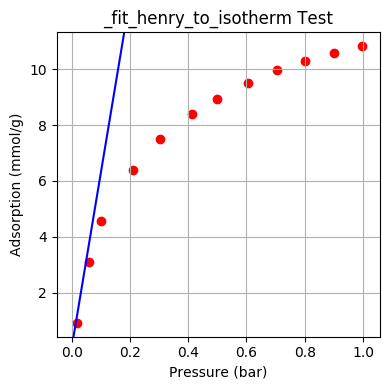

In [25]:
pressure, adsorption = convert_units(test_isotherm)
H, _ = _fit_henry_to_isotherm(test_isotherm)
fig, ax = plt.subplots(figsize=(4,4))
ax.scatter(pressure, adsorption, c="red")
old_ylim = ax.get_ylim()
ax.plot([0, pressure[end]], [0, pressure[end]*H], c="blue")
ax.set_ylim(old_ylim)
ax.set_xlabel("Pressure (bar)")
ax.set_ylabel("Adsorption (mmol/g)")
ax.set_title("_fit_henry_to_isotherm Test")
ax.grid("on")
plt.tight_layout()
plt.show()

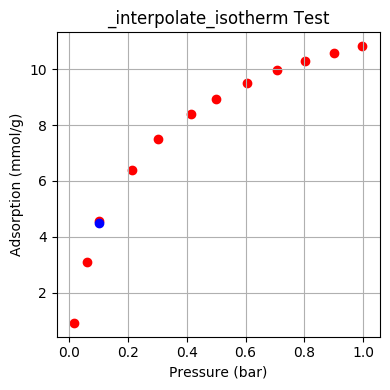

In [26]:
pressure, adsorption = convert_units(test_isotherm)
interpolated_adsorption = _interpolate_isotherm(test_isotherm)
fig, ax = plt.subplots(figsize=(4,4))
ax.scatter(pressure, adsorption, c="red")
old_ylim = ax.get_ylim()
ax.scatter(0.1, interpolated_adsorption, c="blue")
ax.set_ylim(old_ylim)
ax.set_xlabel("Pressure (bar)")
ax.set_ylabel("Adsorption (mmol/g)")
ax.set_title("_interpolate_isotherm Test")
ax.grid("on")
plt.tight_layout()
plt.show()

### We'll also need a function to get rid of columns and/or rows that contain too few values

In [27]:
function prune(H::Array{Union{Float64, Missing}, 2}, min_entries::Int=5)
    nm, ng = size(H)
    keep_col = trues(ng)
    keep_row = trues(nm)
    nb_kept_rows_and_cols = sum(keep_row) + sum(keep_col)
    nb_cut_cols = 0
    nb_cut_rows = 0
    count = 0
    
    while true
        for i_row = 1:nm
            if sum(.!ismissing.(H[i_row, keep_col])) < min_entries
                keep_row[i_row] = false
            end
        end
        
        for i_col = 1:ng
            if sum(.!ismissing.(H[keep_row, i_col])) < min_entries
                keep_col[i_col] = false
            end
        end
        
        if nb_kept_rows_and_cols == (sum(keep_row) + sum(keep_col))
            break
        end
        
        nb_kept_rows_and_cols = sum(keep_row) + sum(keep_col)
        count += 1
    end
    
    rows_cut = sum(.!keep_row)
    cols_cut  = sum(.!keep_col)
    
    @printf("Minimum entries required in each column/row of H: %d\n", min_entries)
    @printf("Number of gases cut: %d\n", cols_cut)
    @printf("Number of materials cut: %d\n", rows_cut)
    @printf("Dimensions of H went from (%d, %d) to (%d, %d)\n", nm, ng, nm-rows_cut, ng-cols_cut)
    @printf("Number of iterations required to prune H: %d\n", count)
    
    return keep_row, keep_col
end

prune (generic function with 2 methods)

### Before we start filling <b>H</b>, lets merge some materials together that should be listed under the same material but aren't

In [28]:
function delete_materials(master_list_of_materials::Array{AbstractString, 1}, to_be_deleted::Array{<:AbstractString, 1})
    to_keep = trues(length(master_list_of_materials))
    for material in to_be_deleted
        if !(material in master_list_of_materials)
            @warn @sprintf("%s does not exist in the master list of materials.", material)
        else
            delete_index = findfirst(master_list_of_materials .== material)
            to_keep[delete_index] = false
        end
    end
    return master_list_of_materials[to_keep]
end


delete_materials (generic function with 1 method)

In [29]:
master_list_of_materials = delete_materials(master_list_of_materials, ["Pillared Layered Materials", "should_not_exist"])

┌ Warning: should_not_exist does not exist in the master list of materials.
└ @ Main In[28]:5


7006-element Array{AbstractString,1}:
 "Li-FAU(1.0)"                                                                    
 "Soc-MOF"                                                                        
 "MIL-140C-25"                                                                    
 "MOF-GO PSN"                                                                     
 "HFCP-17"                                                                        
 "36 wt% CuCl/NaX"                                                                
 "Coal RU1"                                                                       
 "MG-A-900"                                                                       
 "CMS-3K"                                                                         
 "[Zn11(H2O)2(ur)4(bpdc)11]"                                                      
 "CuMOF"                                                                          
 "Hydrated MIL-53"                               

In [30]:
# Return a new master_list_of_materials
# Also modifies the pre-existing `isotherm_dictionary`
function merge_materials(master_list_of_materials::Array{AbstractString, 1}, target::AbstractString, to_be_merged::Array{<:AbstractString, 1})
    # First we delete the MOFs that are to be merged from the master list of materials
    index_of_to_be_merged = [(mof in to_be_merged) for mof in master_list_of_materials]
    new_master_list_of_materials = master_list_of_materials[.!index_of_to_be_merged]

    # Then we combine the isotherms from the merged materials with the target material
    for gas_key in keys(isotherm_dictionary)
        for merging_material in to_be_merged
            if haskey(isotherm_dictionary[gas_key], merging_material)
                if !haskey(isotherm_dictionary[gas_key], target)
                    isotherm_dictionary[gas_key][target] = Array{AbstractString, 1}()
                end
                append!(isotherm_dictionary[gas_key][target], isotherm_dictionary[gas_key][merging_material])
            end
        end
    end
    return new_master_list_of_materials
end

merge_materials (generic function with 1 method)

In [31]:
new_master_list_of_materials = merge_materials(master_list_of_materials, "Mg-MOF-74", 
                                                            ["CPO-27-Mg", "CPO-27-Mg(100%)", "CPO-27-Mg-a", "CPO-27-Mg-b", "CPO-27-Mg-c", "Mg-MOF-74 (3)", 
                                                             "Mg-MOF-74 (4)", "MOF-74(Mg)-1st cycle", "Mg-MOF-74(C)", "Mg-MOF-74(C)-TEA", "Mg-MOF-74(S)",
                                                             "Mg-DOBDC", "Mg2(dobdc)"])
new_master_list_of_materials = merge_materials(new_master_list_of_materials, "CPO-27-Co",
                                                            ["Co-MOF-74(M)", "Co-MOF-74(S)", "Co-DOBDC", "Co2(dobdc)"])
new_master_list_of_materials = merge_materials(new_master_list_of_materials, "CPO-27-Ni",
                                                            ["Ni-MOF-74 (1)", "Ni-MOF-74 (2)", "MOF-74-Ni", "MOF-74Ni 70C", "Ni-DOBDC", "Ni2(dobdc)"])
new_master_list_of_materials = merge_materials(new_master_list_of_materials, "Mn-MOF-74",
                                                            ["CPO-27-Mn", "Mn-DOBDC", "Mn2(dobdc)"])
new_master_list_of_materials = merge_materials(new_master_list_of_materials, "Zn-MOF-74",
                                                            ["Zn-MOF-74(cycle 1)", "Zn-MOF-74(cycle 2)", "Zn-MOF-74(cycle 3)", "Zn-MOF-74(cycle 4)",
                                                             "Zn-MOF-74(cycle 5)", "CPO-27-Zn", "MOF-74", "MOF-74 (DMF)", "MOF-74 (water)",
                                                             "Zn-DOBDC", "Zn2(dobdc)"])
new_master_list_of_materials = merge_materials(new_master_list_of_materials, "Cu-BDC",
                                                            ["Cu(BDC) (60mL DMF 100W Microwave)", "Cu(BDC) (60mL DMF 300W Microwave)",
                                                             "Cu(BDC) (87mL DMF 100W Microwave)", "Cu(BDC) (87mL DMF 300W Microwave)"])
new_master_list_of_materials = merge_materials(new_master_list_of_materials, "CuBTC",
                                                            ["Cu-BTC (diethylene glycol)", "Cu-BTC (ethylene glycol)", "Cu-HKUST-1", "CuBTC 100/100",
                                                             "CuBTC 50/110", "CuBTC 75/110", "CuBTC 75/140", "CuBTC 75/80", "Cu2(BTC)3", "CuBTC(Cu)",
                                                             "CuBTC-MW", "HKUST-1 (0T)", "HKUST-1 (1 pot)"])
new_master_list_of_materials = merge_materials(new_master_list_of_materials, "Cu-SDU-1",
                                                            ["Cu-SDU-1 (100 degrees C)", "Cu-SDU-1 (40 degrees C)", "Cu-SDU-1 (80 degrees C)"])
new_master_list_of_materials = merge_materials(new_master_list_of_materials, "Fe-MOF-74",
                                                            ["CPO-27-Fe", "Fe2(dobdc)"])
new_master_list_of_materials = merge_materials(new_master_list_of_materials, "IRMOF-1",
                                                            ["MOF-5 (1.5 hours activated)", "MOF-5 (Na2BDC 298)", "MOF-5 (Na2BDC 373)", "MOF-5-.5h in humid air",
                                                             "MOF-5-24h in humid air", "MOF-5-2h in humid air", "MOF-5-48h in humid air", "MOF-5-40h", 
                                                             "MOF-5-61% humidity", "MOF-5-61% humidity-exposedtoair.5h", "MOF-5-61% humidity-exposedtoair24h",
                                                             "MOF-5-61% humidity-exposedtoair2h", "MOF-5-61% humidity-exposedtoair48h", "MOF-5-BPO",
                                                             "MOF-5-BPO (cBPO = .04 M)", "MOF-5-BPO (cBPO = .06 M)"])
new_master_list_of_materials = merge_materials(new_master_list_of_materials, "Ni(bodc)(ted)0.5",
                                                            ["Ni-bodc-ted"])
new_master_list_of_materials = merge_materials(new_master_list_of_materials, "Ni(bdc)(ted)0.5",
                                                            ["Ni(bdc)(ted)0.5 t=100", "Ni(bdc)(ted)0.5 t=15"])
new_master_list_of_materials = merge_materials(new_master_list_of_materials, "PCN-14",
                                                            ["PCN-14(440)", "PCN-14(450)", "PCN-14(500)", "PCN-14(550)", "PCN-14(600)"])
new_master_list_of_materials = merge_materials(new_master_list_of_materials, "UiO-66",
                                                            ["UiO-66 (24h)", "UiO-66 (2h)", "UiO-66 (48h)", "UiO-66 (4h)", "UiO-66 (72h)",
                                                             "UiO-66 (8h)", "UiO-66 (solvothermal)", "UiO-66(Zr)", "UiO-66(Zr) 100 Equ. FA",
                                                             "UiO-66(Zr) 30 Equ. AA"])
new_master_list_of_materials = merge_materials(new_master_list_of_materials, "UiO-66-NH2",
                                                            ["UiO-66-NH2(100)", "UiO-66-NH2(67)", "UiO-66-NH2(33)"])
new_master_list_of_materials = merge_materials(new_master_list_of_materials, "UiO-66-(COOH)2",
                                                            ["UiO-66(Zr)-(COOH)2", "UiO-66(Zr)-(COOH)2 (303K)", "UiO-66(Zr)-(COOH)2 (323K)", 
                                                             "UiO-66(Zr)-(COOH)2 (343K)", "UiO-66(Zr)-(COOH)2 (348K)", "UiO-66(Zr)-(COOH)2 (373K)",
                                                             "UiO-66(Zr)-(COOH)2 (383K)", "UiO-66(Zr)-(COOH)2 (423K)", "UiO-66(Zr)-(COOH)2 (463K)", 
                                                             "UiO-66(Zr)-(COOH)2 (473K)"])
new_master_list_of_materials = merge_materials(new_master_list_of_materials, "SNU-9",
                                                            ["SNU-9 (10 cycles)", "SNU-9 (100 cycles)"])
new_master_list_of_materials = merge_materials(new_master_list_of_materials, "ZIF-8",
                                                            ["ZIF-8 (BULK)", "ZIF-8 (crystal = 0.060 micrometers)", "ZIF-8 (crystal = 0.33 micrometers)", 
                                                             "ZIF-8 (crystal = 0.47 micrometers)", "ZIF-8 (crystal = 0.73 micrometers)", 
                                                             "ZIF-8 (crystal = 1.2 micrometers)", "ZIF-8 (crystal = 2.1 micrometers)",
                                                             "ZIF-8 (crystal = 88 micrometers)", "ZIF-8 (Large Size)", "ZIF-8 (Middle Size)", "ZIF-8 (Small Size)",
                                                             "ZIF-8-0.025 WT% CTAB", "ZIF-8-C_100_2d", "ZIF-8-C_200_2d", "ZIF-8-C_250_2d", "ZIF-8-C_250_2d_V",
                                                             "ZIF-8-M_100_7d", "ZIF-8-M_200_2d", "ZIF-8-M_250_2d", "ZIF-8-M_250_2d_V", "ZIF-8-W_100_7d",
                                                             "ZIF-8-W_200_2d", "ZIF-8-W_250_2d", "ZIF-8-W_250_2d_V", "ZIF-8ER", "ZIF-8HP", "ZIF-8HT",
                                                             "ZIF-8LT", "ZIF-8LT-HT"])
new_master_list_of_materials = merge_materials(new_master_list_of_materials, "MCM-41",
                                                            ["2650 K MCM-41", "300 K MCM-41", "MCM-41 d=2.8 nm", "MCM-41 d=3.1 nm",
                                                             "MCM-41 1000C", "MCM-41 500C", "MCM-41 700C", "MCM-41 900C"])
master_list_of_materials = merge_materials(new_master_list_of_materials, "Cu-MOF-74",
                                                            ["Cu-DOBDC (DREIDING Parameters-Universal Force Field + TraPPe Model)", 
                                                             "CPO-27-Cu", "Cu2(dobdc)"])

6863-element Array{AbstractString,1}:
 "Li-FAU(1.0)"                                                                    
 "Soc-MOF"                                                                        
 "MIL-140C-25"                                                                    
 "MOF-GO PSN"                                                                     
 "HFCP-17"                                                                        
 "36 wt% CuCl/NaX"                                                                
 "Coal RU1"                                                                       
 "MG-A-900"                                                                       
 "CMS-3K"                                                                         
 "[Zn11(H2O)2(ur)4(bpdc)11]"                                                      
 "CuMOF"                                                                          
 "Hydrated MIL-53"                               

## Lets create the function that fills in <b>H</b>

In [32]:
function fill_H(filter_functions::Array{<:Function, 1}, fit_function::Function, post_functions::Array{<:Function, 1}, max_value_of_h::Float64=1e7; 
                verbose::Bool=false)
    nm = length(master_list_of_materials)
    ng = length(master_list_of_gases)
    H = Array{Union{Float64, Missing}, 2}(undef, nm, ng)
    fill!(H, missing)
    MSE = Array{Union{Float64, Missing}, 2}(undef, nm, ng)
    fill!(MSE, missing)

    for (j, gas) in enumerate(master_list_of_gases)
        if !haskey(isotherm_dictionary, gas)
            continue
        end
        for (i, material) in enumerate(master_list_of_materials)
            if !haskey(isotherm_dictionary[gas], material)
                continue
            end
            isotherm_list = isotherm_dictionary[gas][material]
            isotherms = read_isotherm.(isotherm_list)
            ### Lets run the validity functions to see which isotherm files are valid
            valid_isotherms = trues(length(isotherm_list))
            for filter_func in filter_functions
                valid_isotherms .= valid_isotherms .& filter_func.(isotherms)
            end
            
            fit_vals = Array{Union{Missing, Float64}, 1}(undef, sum(valid_isotherms))
            fill!(fit_vals, missing)
            mse_vals = Array{Union{Missing, Float64}, 1}(undef, sum(valid_isotherms))
            fill!(fit_vals, missing)

            ### Lets run the fitting function now
            fit_vals, mse_vals = fit_function(isotherms[valid_isotherms], 0.05; verbose=verbose)

                
            for k = 1:length(fit_vals)
                if typeof(fit_vals[k]) == Missing
                    continue
                elseif fit_vals[k] > max_value_of_h
                    fit_vals[k] = missing
                end
            end
                            
            if length(collect(skipmissing(fit_vals))) == 0
                continue
            end

            # Lets take the median of the fitted values to try to remove the effects of outlieres
            H[i,j] = median(skipmissing(fit_vals))
            MSE[i,j] = median(skipmissing(mse_vals))
            
                
            ### And finally lets run the post processing functions
            for post_func in post_functions
                H[i,j] = post_func(H[i,j])
            end
        end
    end
    return H, MSE
end
                    
H, MSE = fill_H([_check_nb_of_adsorbates, _check_temperature, _check_units, _check_category], _fit_henry_to_isotherm, [log10]; verbose=false)

(Union{Missing, Float64}[missing missing … missing missing; missing missing … missing missing; … ; missing missing … missing missing; missing missing … missing missing], Union{Missing, Float64}[missing missing … missing missing; missing missing … missing missing; … ; missing missing … missing missing; missing missing … missing missing])

In [33]:
function check_sparsity(H::Array{Union{Float64, Missing}, 2})
    sparsity = sum(ismissing.(H)) / length(H) * 100
    @printf("Sparsity is %.3f%%\n", sparsity)
    return sparsity
end

check_sparsity (generic function with 1 method)

In [34]:
check_sparsity(H)
keep_row, keep_col = prune(H)
H = H[keep_row, keep_col]
MSE = MSE[keep_row, keep_col]
master_list_of_gases = master_list_of_gases[keep_col]
master_list_of_materials = master_list_of_materials[keep_row]
check_sparsity(H);

Sparsity is 99.823%
Minimum entries required in each column/row of H: 5
Number of gases cut: 322
Number of materials cut: 6758
Dimensions of H went from (6863, 356) to (105, 34)
Number of iterations required to prune H: 2
Sparsity is 78.711%


## standardize columns
* standardize the columns (representing $H$'s for a certain gas) so that each column has mean zero and variance of one

In [35]:
nm, ng = size(H)
# standardize the columns
for j = 1:ng
    # find ids that are not missing
    ids = .! ismissing.(H[:, j])
    # Hij <-- (Hij - μ_j) / σ_j 
    H[:, j] .= (H[:, j] .- mean(H[ids, j])) ./ std(H[ids, j])
end
# Udell ?: does it make sense to normalizes gases but not MOFs? 
#  Cory's justification: gases exhibit tons of variance in the means

In [36]:
@save joinpath("data", "logH_matrix_materials_and_gases.jld2") H master_list_of_materials master_list_of_gases MSE

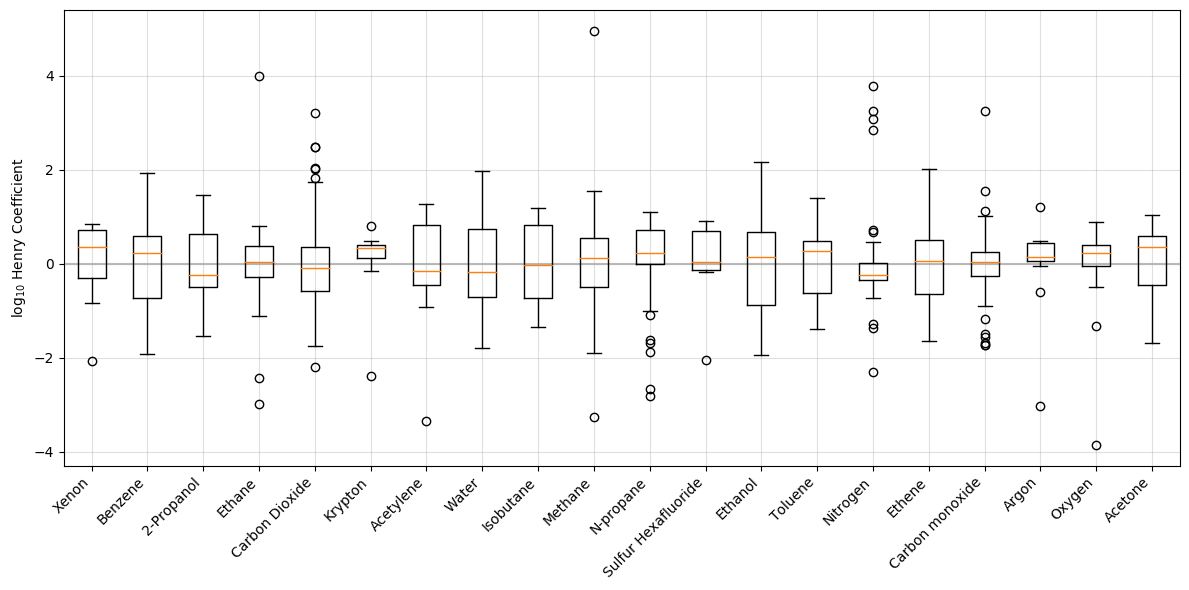

In [38]:
function h_dist_for_gas(gases::Array{<:Union{AbstractString, Int}, 1})
    gas_Hs = Array{Array{Float64, 1}, 1}()
    gases = convert(Array{Union{AbstractString, Int}, 1}, gases)
    for i in 1:length(gases)
        if typeof(gases[i]) <: AbstractString
            @assert gases[i] in master_list_of_gases
            gases[i] = findfirst(gases[i] .== master_list_of_gases)
        end
        push!(gas_Hs, collect(skipmissing(H[:, gases[i]])))
    end
    fig, ax = plt.subplots(figsize=(12,6))
    #violin_parts = ax.violinplot(gas_Hs, showmedians=true)
    ax.boxplot(gas_Hs)
    # Make color of violins orange
    #for piece in violin_parts["bodies"]
    #    piece.set_facecolor("#f58231")
    #    piece.set_edgecolor("k")
    #end
    ## Make the max, min, median bars maroon
    #for partname in ["cbars", "cmins", "cmaxes", "cmedians"]
    #    piece = violin_parts[partname]
    #    piece.set_edgecolor("#800000")
    #end
    xlim = ax.get_xlim()
    ax.plot(xlim, [0, 0], c="#a9a9a9", alpha=0.8, zorder=.8)
    ax.set_xlim(xlim)
    ax.set_xticks(1:length(gases))
    ax.set_xticklabels([master_list_of_gases[i] for i in gases], rotation=45, ha="right")
    #ax.set_xlabel(master_list_of_gases[gases])
    ax.set_ylabel(L"log$_{10}$ Henry Coefficient")
    #ax.set_title("MSE Distribution for " * master_list_of_gases[gases])
    plt.tight_layout()
    plt.grid("on", alpha=0.4)
    plt.show()
    return gas_Hs
end

#h_dist_for_gas(["Water", "Carbon Dioxide"])
h_dist_for_gas(master_list_of_gases[1:20]);

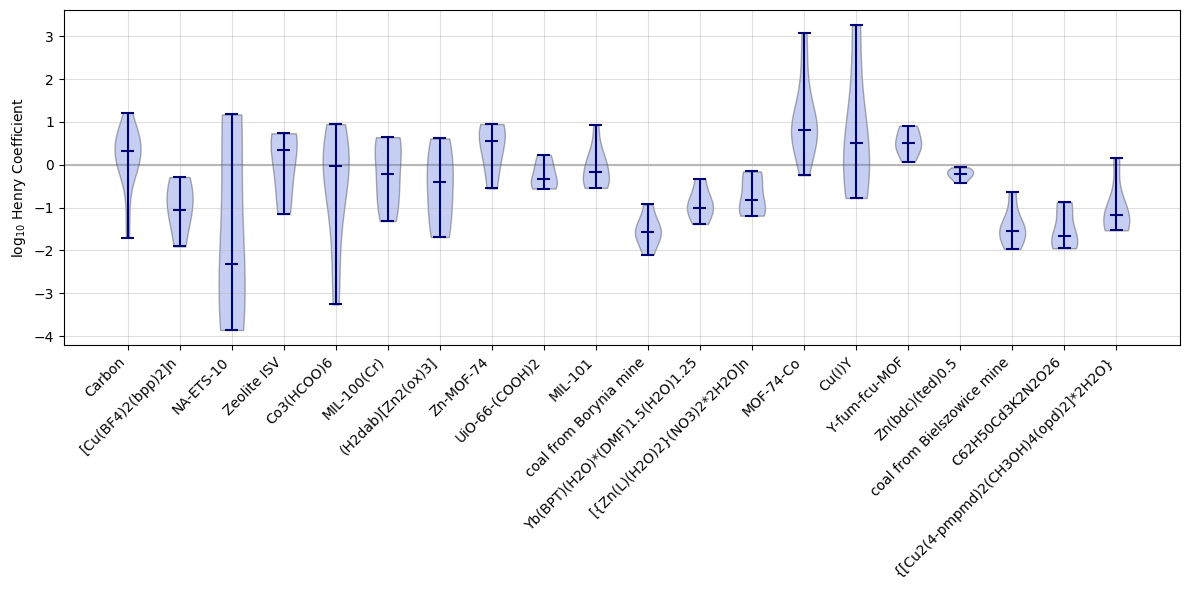

In [39]:
function h_dist_for_mof(mofs::Array{<:Union{AbstractString, Int}, 1})
    mof_Hs = Array{Array{Float64, 1}, 1}()
    mofs = convert(Array{Union{AbstractString, Int}, 1}, mofs)
    for i in 1:length(mofs)
        if typeof(mofs[i]) <: AbstractString
            @assert mofs[i] in master_list_of_materials
            mofs[i] = findfirst(mofs[i] .== master_list_of_materials)
        end
        push!(mof_Hs, collect(skipmissing(H[mofs[i], :])))
    end
    fig, ax = plt.subplots(figsize=(12,6))
    violin_parts = ax.violinplot(mof_Hs, showmedians=true)
    # Make color of violins blue
    for piece in violin_parts["bodies"]
        piece.set_facecolor("#4363d8")
        piece.set_edgecolor("k")
    end
    # Make the max, min, median bars navy
    for partname in ["cbars", "cmins", "cmaxes", "cmedians"]
        piece = violin_parts[partname]
        piece.set_edgecolor("#000075")
    end
    xlim = ax.get_xlim()
    ax.plot(xlim, [0, 0], c="#a9a9a9", alpha=0.8, zorder=.8)
    ax.set_xlim(xlim)
    ax.set_xticks(1:length(mofs))
    ax.set_xticklabels([master_list_of_materials[i] for i in mofs], rotation=45, ha="right")
    #ax.set_xlabel(master_list_of_gases[gases])
    ax.set_ylabel(L"log$_{10}$ Henry Coefficient")
    #ax.set_title("MSE Distribution for " * master_list_of_gases[gases])
    plt.tight_layout()
    plt.grid("on", alpha=0.4)
    plt.show()
    return mof_Hs
end

#h_dist_for_gas(["Water", "Carbon Dioxide"])
h_dist_for_mof(master_list_of_materials[1:20]);

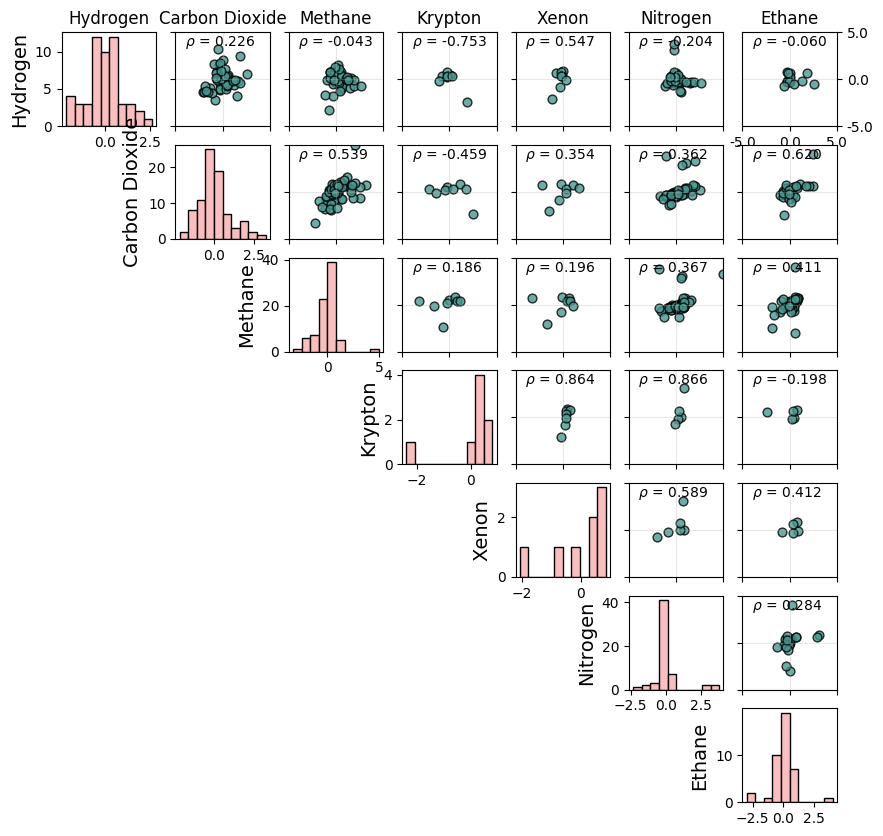

In [40]:
function plot_scatter_plot_matrix(H::Array{Union{Float64, Missing}, 2}, gases::Array{<:Union{AbstractString, Int}, 1})
    N = length(gases)
    
    temp_H = deepcopy(H)
    mean_H = [mean(skipmissing(temp_H[:, i])) for i = 1:size(H)[2]]
    temp_H = temp_H .- mean_H'
    
    
    gases = convert(Array{Union{AbstractString, Int}, 1}, gases)
    for i in 1:length(gases)
        if typeof(gases[i]) <: AbstractString
            @assert gases[i] in master_list_of_gases
            gases[i] = findfirst(gases[i] .== master_list_of_gases)
        end
    end
    
    fig, axs = subplots(N, N, figsize=(10,10))
    #println(axs)
    for i = 1:N
        for j = 1:N
            if i == 1
                axs[i,j].title.set_text(master_list_of_gases[gases[j]])
            end

            if i > j
                axs[i,j].axis("off")
            elseif i == j
                x = collect(skipmissing(temp_H[:, gases[i]]))
                #println(typeof(x))
                axs[i,j].hist(x, fc="#fabebe", ec="k")
                axs[i,j].set_ylabel(master_list_of_gases[gases[i]], fontsize=14)
            else
                axs[i,j].set_xticklabels([])
                axs[i,j].set_yticklabels([])
                observed_in_both_gases = (.! ismissing.(temp_H[:, gases[i]])) .& (.! ismissing.(temp_H[:, gases[j]]))
                if sum(observed_in_both_gases) == 0
                    axs[i,j].set_facecolor("yellow")
                    continue
                end
                a = temp_H[observed_in_both_gases, gases[i]]
                b = temp_H[observed_in_both_gases, gases[j]]
                ρ = cor(a, b)
                axs[i,j].scatter(a, b, s=40, fc="#469990", ec="k", alpha=0.8)
                axs[i,j].set_xlim([-5, 5])
                axs[i,j].set_ylim([-5, 5])
                axs[i,j].grid("on", alpha=0.3, zorder=0.9)
                axs[i,j].text(-4, 3.5, @sprintf("\$\\rho\$ = %.3f", ρ), zorder=99)
            end
        end
    end
    axs[1, N].yaxis.tick_right()
    axs[1, N].xaxis.tick_bottom()
    axs[1, N].set_xticklabels(axs[1, N].get_xticks())
    axs[1, N].set_yticklabels(axs[1, N].get_yticks())
    plt.savefig("Distn_of_gases.png", dpi=300, format="png")
    plt.show()
    return nothing
end
plot_scatter_plot_matrix(H, ["Hydrogen", "Carbon Dioxide", "Methane", "Krypton", "Xenon", "Nitrogen", "Ethane"])

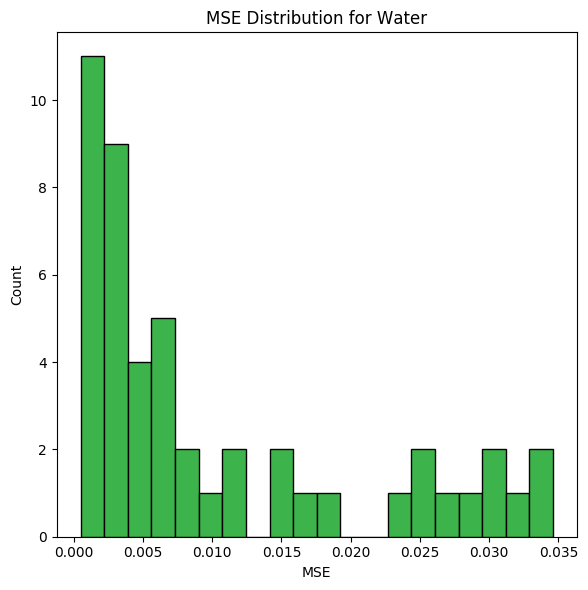

48-element Array{Float64,1}:
 0.02673887490808396  
 0.007962453386614025 
 0.02518146435726103  
 0.003336677864673869 
 0.0030237305754698828
 0.034617662965427044 
 0.0044913766092255425
 0.016674724343755862 
 0.0009345670088765673
 0.006691845038562313 
 0.003936278073730237 
 0.01787581352121703  
 0.033179901213884255 
 ⋮                    
 0.0010766645641072622
 0.0007234981497051721
 0.002741275899491784 
 0.0036310753293246185
 0.0041052497064428   
 0.024789413167851066 
 0.03282452986108093  
 0.0026886948156315043
 0.0004885048945016665
 0.009881706563214637 
 0.0066327560470935566
 0.0009731430865910148

In [41]:
function plot_mse_distribution_per_gas(gas::Union{AbstractString, Int})
    if typeof(gas) <: AbstractString
        @assert gas in master_list_of_gases
        gas = findfirst(gas .== master_list_of_gases)
    end
    gas_mses = collect(skipmissing(MSE[:, gas]))
    
    fig, ax = plt.subplots(figsize=(6,6))
    ax.hist(gas_mses, bins=20, fc="#3cb44b", ec="k")
    ax.set_xlabel("MSE")
    ax.set_ylabel("Count")
    ax.set_title("MSE Distribution for " * master_list_of_gases[gas])
    plt.tight_layout()
    plt.show()
    return gas_mses
end

plot_mse_distribution_per_gas("Water")

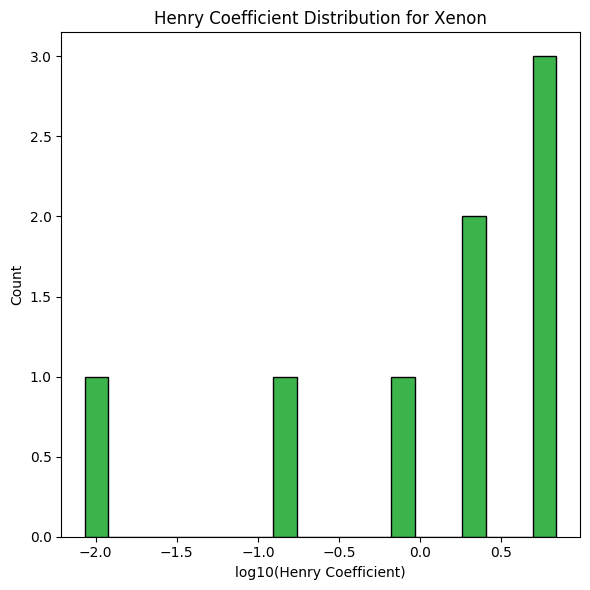

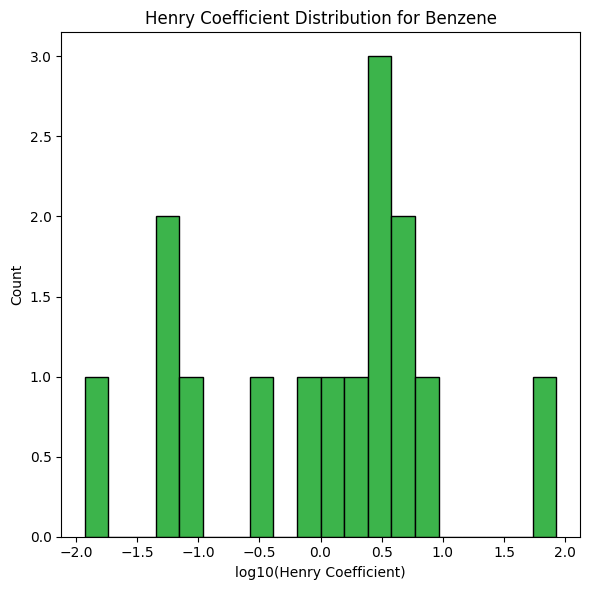

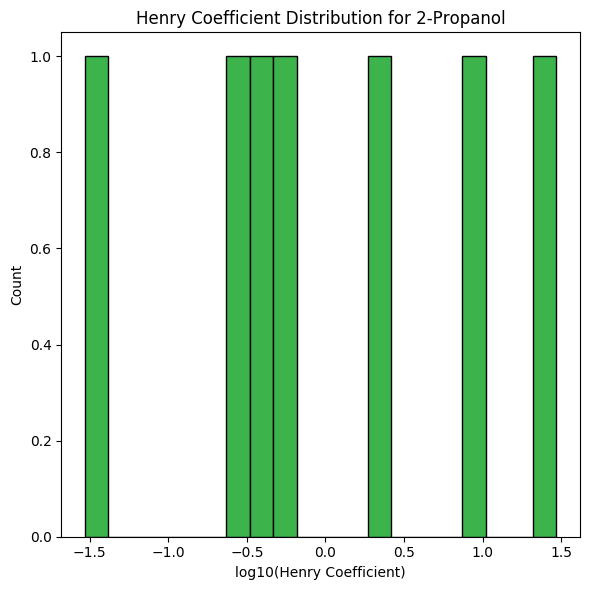

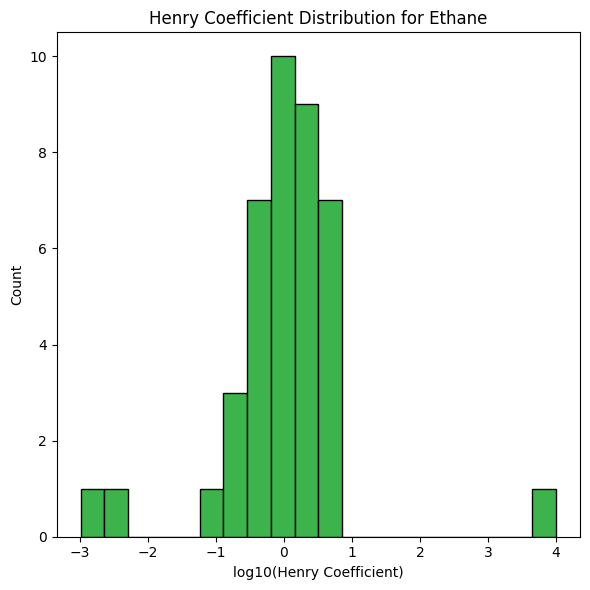

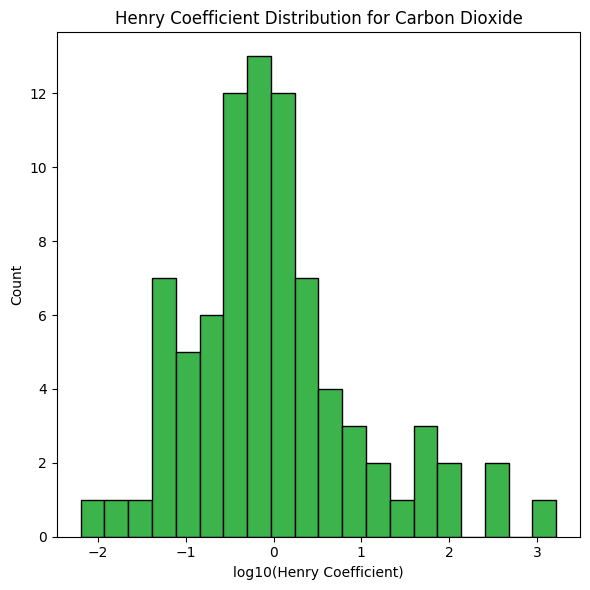

5-element Array{Array{Float64,1},1}:
 [0.839669099920442, 0.6996287785378638, 0.7544143404513474, -0.8281789940126453, -2.066475346321659, 0.3505626205387351, 0.376082632537912, -0.12570313165199584]                                                                                                                                                                                                                                                                    
 [-1.1878196983029634, -1.9268011530729596, 0.1527569258540141, 0.6797560279432266, 0.23311260548822202, 1.928581563673767, 0.7400972254375138, 0.5181907343249775, -0.13146545010519142, 0.4130386459046576, -0.4711454991978817, 0.8125638558576805, 0.46720175340203784, -0.990456408833683, -1.2376111283734204]                                                                                                                  
 [-0.4052904548016861, -1.529642245096665, 0.38560868173249363, 1.4681259266186721, -0.5800437675798098, -0.233637560

In [42]:
function plot_H_distribution_per_gas(gas::Union{AbstractString, Int})
    if typeof(gas) <: AbstractString
        @assert gas in master_list_of_gases
        gas = findfirst(gas .== master_list_of_gases)
    end
    gas_Hs = collect(skipmissing(H[:, gas]))
    
    fig, ax = plt.subplots(figsize=(6,6))
    ax.hist(gas_Hs, bins=20, fc="#3cb44b", ec="k")
    ax.set_xlabel("log10(Henry Coefficient)")
    ax.set_ylabel("Count")
    ax.set_title("Henry Coefficient Distribution for " * master_list_of_gases[gas])
    plt.tight_layout()
    plt.show()
    return gas_Hs
end

plot_H_distribution_per_gas.(1:5)

## Sanity Check

In [54]:
gas = 7
@show master_list_of_gases[gas]
material = 41
@show master_list_of_materials[material]

master_list_of_gases[gas] = "Acetylene"
master_list_of_materials[material] = "[Cu3(TDPAH)(H2O)3] 13H2O 8DMA"


"[Cu3(TDPAH)(H2O)3] 13H2O 8DMA"

In [55]:
sanity_isotherms = isotherm_dictionary[master_list_of_gases[gas]][master_list_of_materials[material]]

2-element Array{AbstractString,1}:
 "10.1039C4cc00375f.Isotherm7"
 "10.1039C4cc00375f.Isotherm8"

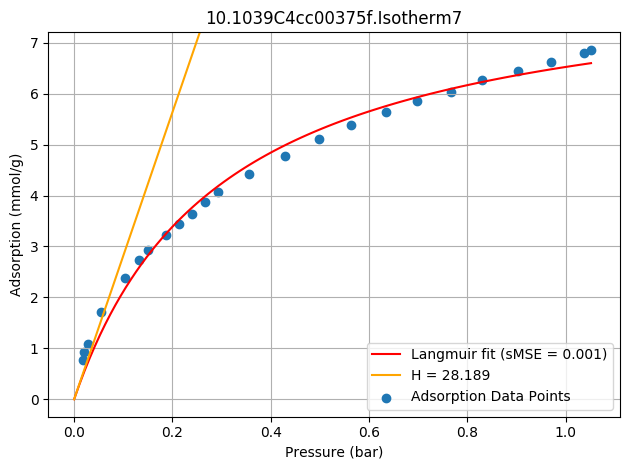

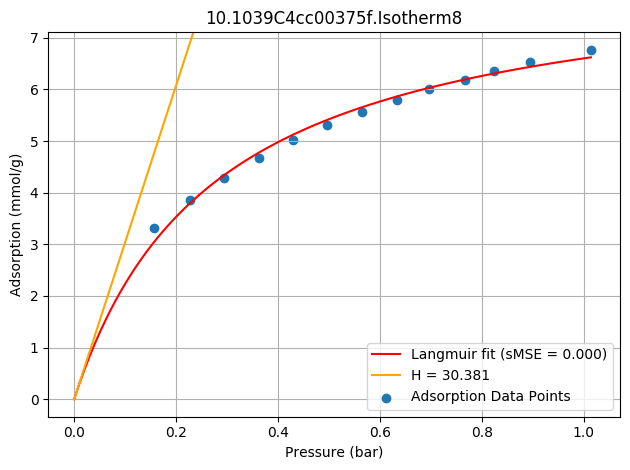

Isotherm filename: 10.1039C4cc00375f.Isotherm7
iso["temperature"] = 298
iso["adsorptionUnits"] = "cm3(STP)/g"
iso["pressureUnits"] = "bar"
iso["category"] = ""
((iso["adsorbates"])[1])["name"] = "Acetylene"
(iso["adsorbent"])["name"] = "[Cu3(TDPAH)(H2O)3] 13H2O 8DMA"
--------------------
Isotherm filename: 10.1039C4cc00375f.Isotherm8
iso["temperature"] = 298
iso["adsorptionUnits"] = "cm3(STP)/g"
iso["pressureUnits"] = "bar"
iso["category"] = ""
((iso["adsorbates"])[1])["name"] = "Acetylene"
(iso["adsorbent"])["name"] = "[Cu3(TDPAH)(H2O)3] 13H2O 8DMA"
--------------------


In [56]:
sanity_Hs = Array{Union{Float64, Missing}, 1}(undef, length(sanity_isotherms))
for (i, isotherm) in enumerate(sanity_isotherms)
    @printf("Isotherm filename: %s\n", isotherm)
    iso = read_isotherm(isotherm)
    @show iso["temperature"]
    @show iso["adsorptionUnits"]
    @show iso["pressureUnits"]
    @show iso["category"]
    @show iso["adsorbates"][1]["name"]
    @show iso["adsorbent"]["name"]

    valid = true
    valid = valid && _check_nb_of_adsorbates(iso)
    valid = valid && _check_temperature(iso)
    valid = valid && _check_units(iso)
    valid = valid && _check_category(iso)
    if !valid
        @printf("%s is not a valid isotherm. Continuing\n", isotherm)
        @printf("--------------------\n")
        continue
    end
    pressure, adsorption = convert_units(iso)
    MSE_threshold = 0.05
    # Henry/Langmuir fit
    params = Dict()
    try
        isotherm_df = DataFrame(:p => pressure, :a => adsorption)
        options = Optim.Options(iterations=5000)
        params = fit_adsorption_isotherm(isotherm_df, :p, :a, :langmuir, options)
    catch err
        if isa(err, FitError)
            @printf("It's a FitError! Continuing.\n")
            continue
        elseif isa(err, KeyError)
            @printf("Atomic Mass not available for an element in %s! Continuing.\n", iso["adsorbates"][1]["name"])
            continue
        else
            println(err)
            error("Something went wrong")
        end
    end
    sanity_Hs[i] = params["M"] * params["K"]
    sanity_MSE = params["MSE"]/maximum(adsorption)^2
    if params["M"] <= 0 || params["K"] <= 0
        @warn @sprintf("Optimization of %s resulted in a negative Henry coefficient\n", iso["filename"])
    elseif sanity_MSE >= MSE_threshold
        @warn @sprintf("MSE of henry fit of file %s is too large\n", iso["filename"])
    end
    
    
    
    
    fig,ax = plt.subplots()
    ax.scatter(pressure, adsorption, label="Adsorption Data Points")
    temp_p = range(0, maximum(pressure), length=101)
    temp_a = params["M"] * params["K"] .* temp_p ./ (1 .+ params["K"] .* temp_p)
    ax.plot(temp_p, temp_a, c="red", label=@sprintf("Langmuir fit (sMSE = %.3f)", sanity_MSE))
    old_ylim = ax.get_ylim()
    ax.plot([0, maximum(pressure)], [0, maximum(pressure) * sanity_Hs[i]], c="orange", label=@sprintf("H = %.3f", sanity_Hs[i]))
    ax.set_ylim(old_ylim)
    ax.set_xlabel("Pressure (bar)")
    ax.set_ylabel("Adsorption (mmol/g)")
    ax.set_title(isotherm)
    plt.legend()
    plt.show(fig)
    plt.tight_layout()
    plt.grid("on")
    @printf("--------------------\n")
end

In [57]:
@show sanity_Hs
@show sanity_H = median(skipmissing(sanity_Hs))
@show log10_sanity_H = log10(sanity_H)
@show H[material,gas]
@assert H[material, gas] == log10_sanity_H

sanity_Hs = Union{Missing, Float64}[28.188926506250947, 30.38132395766521]
sanity_H = median(skipmissing(sanity_Hs)) = 29.285125231958077
log10_sanity_H = log10(sanity_H) = 1.4666470855411022
H[material, gas] = 1.0127858887251748


AssertionError: AssertionError: H[material, gas] == log10_sanity_H